<a href="https://colab.research.google.com/github/ArtuomMerkulov/-/blob/main/%D0%A0%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D1%81%D1%82%D0%BE%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8_%D0%B0%D1%80%D0%B5%D0%BD%D0%B4%D1%8B_%D0%BF%D0%BE%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D1%8F_%E2%84%962.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [1]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами

from tensorflow.keras.models import Sequential, Model #
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten #
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop #
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback, LearningRateScheduler # подключаем колбэки

from sklearn.preprocessing import StandardScaler #
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
#from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел
import math # Для округления
import os #Для работы с файлами
import re #
import matplotlib.pyplot as plt #
%matplotlib inline

from keras.callbacks import LambdaCallback
from IPython.display import clear_output
import time
from keras.callbacks import ReduceLROnPlateau

from IPython.display import clear_output


In [2]:
df2 = pd.read_csv('/content/moscow.csv', sep=";") #Загружаем данные в data frame
df2
df1 = df2.drop(['ГРМ','Бонус агенту'], axis = 1)
df1
df = df1.iloc[::2,:] #Выбираем нечётные строки, в чётных строках в исходном фрейме пустые строки для комментариев
df

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."
6,1,Шаболовская м.,12п,8/12 ?,Б,Р,38/15/7,11200000.0,25.07.2019,7.0,Привлекательные,"Предлагаю 1- комн квартиру, в шаговой доступно..."
8,1,Бабушкинская м.,15п,4/14 П,NaN,С,34/17/8,6250000.0,25.07.2019,11.0,Привлекательные,Продается хорошая 1 комнатная квартира. 1 взро...
...,...,...,...,...,...,...,...,...,...,...,...,...
252526,Ст,Некрасовка м.,4п,2/17 П,NaN,NaN,19.8/?/?,2850000.0,12.07.2019,14.0,AVITO.ru,Уникальнейшее предложение! 7 минуты до метро! ...
252528,Ст,Авиамоторная м.,6п,2/8 К,NaN,С,20.4/18/?,3839990.0,23.07.2019,14.0,Яндекс,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...
252530,Ст,Коломенская м.,15п,1/9 П,NaN,NaN,15.4/13.2/?,2900000.0,12.07.2019,14.0,AVITO.ru,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...
252532,Ст,Алтуфьево м.,5т,4/9 М,NaN,NaN,26/10.9/7,5200000.0,22.07.2019,14.0,AVITO.ru,Продается студия с отделкой в новом монолитном...


#Функции парсинга

In [3]:
#d - описание квартиры, одна строка из data1
#количество комнат
#maxRoomCount - максимальное число комнат в квартире
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0] #Получаем строку с числом комнат

  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr) #Пробуем превратить строку в число
    if (roomsCount > maxRoomCount):
      roomsCount = maxRoomCount #Если число комнат больше максимального, то присваиваем максимальное
  except: #Если не получается превратить строку в число
    if (roomsCountStr == roomsCountStr): #Проверяем строку на nan (сравнение с самим собой)
      if ("Ст" in roomsCountStr): #Есть строка = "Ст", значит это Студия
        roomsCount = maxRoomCount + 1

  return roomsCount

#Превращаем число комнат в категорию
def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount) #Получаем число комнат
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount+2) #Превращаем в категорию
  #maxRoomCount+2 потому что 0 зарезервирован на неопознанное число комнат, а maxRoomCount+1 на "Студию"
  return roomsCount

#Получаем индекс станции метро
#allMetroNames - все уникальные названия метро в базе
def getMetro(d, allMetroNames):
  metroStr = d[1] #Получаем строку метро
  metro = 0

  if (metroStr in allMetroNames): #Если находим метро во всех названиях
    metro = allMetroNames.index(metroStr)+1 #Присваиваем индекс
    #+1 так как 0 зарезервирован на неопознанное метро

  return metro

#Получаем тип метро
#0 - внутри кольца
#1 - кольцо
#2 - 1-3 станции от конца
#3 - 4-8 станций от кольца
#4 - больше 8 станций от кольца
def getMetroType(d):
  metroTypeStr = d[1] #Получаем строку метро
  metroTypeClasses = 5 #Число классов метро
  metroType = metroTypeClasses - 1 #Изначально считаем последний класс

  #Метро внутри кольца
  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
  #Метро на кольце
  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
  #Метро 1-3 станции от кольца
  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]
  #Метро 4-8 станций от кольа
  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]

  #Проверяем, в какую категорию попадает наша станция
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3

  #Превращаем результат в категорию
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType


#Вычисляем расстояние до метро
def getMetroDistance(d):
  metroDistanceStr = d[2] #Получаем строку

  metroDistance = 0 #Расстояние до метро
  metroDistanceType = 0 #Тип расстояния - пешком или на транспорте

  #Если строка не равна nan
  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      #Определяем тип расстояния
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1 #Пешком
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2 #На транспорте

      #Выбрасываем последний символ, чтобы осталось только число
      metroDistanceStr = metroDistanceStr[:-1]
      try:
        #Разделяем дистанции на категории
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except: #Если в строке не число, то категория 0
        metroDistance = 0

  #Число классов дистанции
  metroDistanceClasses = 7

  #У нас 7 категорий дистанции по расстоянию
  #И 3 типа дистанции - неопознанный, пешком и транспортом
  #Мы создадим вектор длины 3*7 = 21
  #Будем преобразовывать индекс расстояния 0-6 в 0-20
  #Для типа "Пешком" - ничего не меняем
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses #Для типа "Транспортом" добавляем 7
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses #Для неопознанного типа добавляем 14

  #Превращаем в категории
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance

#Получаем 4 данных
#- этаж квартиры
#- этажность дома
#- индикатор, что последний этаж
#- тип дома
def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3] #Получаем строку типа дома и этажей
  except:
    houseStr = ""

  houseType = 0 #Тип дома
  floor = 0 #Этаж квартиры
  floors = 0 #Этажность дома
  isLastFloor = 0 #Индикатор последнего этажа

  #Проверяем строку на nan
  if (houseStr == houseStr):
    if (len(houseStr) > 1):

      try:
        slashIndex = houseStr.index("/") #Ищем разделитель /
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ") #Ищем разделитель " "
      except:
        print(houseStr)

      #Вытаскиваем строки
      floorStr = houseStr[:slashIndex] #Строка этажа
      floorsStr = houseStr[slashIndex+1:spaceIndex] #Строка этажности дома
      houseTypeStr = houseStr[spaceIndex+1:] #Строка типа дома

      #Выбираем категорию этажа
      try:
        floor = int(floorStr) #Превращаем строку в число
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        if (floorSave < 10):
          floor = 3
        if (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1): #Первый этаж выделяем в отдельную категорию
          floor = 1

        if (floor == floors): #Если этаж последний, включаем индикатор последнего этажа
          isLastFloor = 1
      except:
        floor = 0 #Если строка не парсится в число, то категория этажа = 0 (отдельная)

      #Выбираем категорию этажности дома
      try:
        floors = int(floorsStr) #Превращаем строку в число
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        if (floorsSave < 10):
          floors = 2
        if (floorsSave < 20):
          floors = 3
        if (floorsSave >= 20):
          floors = 4
      except:
        floors = 0 #Если строка не парсится в число, то категория этажности = 0 (отдельная)

      #Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr):
          houseType = 1
        if ("К" in houseTypeStr):
          houseType = 2
        if ("П" in houseTypeStr):
          houseType = 3
        if ("Б" in houseTypeStr):
          houseType = 4
        if ("?" in houseTypeStr):
          houseType = 5
        if ("-" in houseTypeStr):
          houseType = 6

    #Превращаем все категории в one hot encoding
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)


  return floor, floors, isLastFloor, houseType


#Вычисляем тип балкона
def getBalcony(d):
  balconyStr = d[4] #Получаем строку
  #Выписываем все варианты балконов в базе
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  #Проверяем на nan
  if (balconyStr == balconyStr):
    balcony = balconyVariants.index(balconyStr)+1 #Находим индекс строки балкона во всех строках
  else:
    balcony = 0 #Индекс 0 выделяем на строку nan

  #Превращаем в one hot encoding
  balcony = utils.to_categorical(balcony, 16)

  return balcony

#Определяем тип санузла
def getWC(d):
  wcStr = d[5] #Получаем строку
  #Выписываем все варианты санузлов в базе
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  #Проверяем на nan
  if (wcStr == wcStr):
    wc = wcVariants.index(wcStr)+1 #Находим индекс строки санузла во всех строках
  else:
    wc = 0 #Индекс 0 выделяем на строку nan

  #Превращаем в one hot encoding
  wc = utils.to_categorical(wc, 14)

  return wc

#Определяем площадь
def getArea(d):
  areaStr = d[6] #Получаем строку площади

  if ("/" in areaStr):
    slashIndex = areaStr.index("/") #Находим разделитель /
    try:
      area = float(areaStr[:slashIndex]) #Берём число до разделителя и превращаем в число
    except:
      area = 0 #Если не получается, возвращаем 0
  else:
    area = 0 #Или если нет разделителя, возвращаем 0

  return area

#Получаем цену
def getCost(d):
  costStr = d[7] #Загружаем строку

  try:
    cost = float(costStr) #Пробуем превратить в число
  except:
    cost = 0 #Если не получается, возвращаем 0

  return cost

#Получаем комментарий
def getComment(d):
  commentStr = d[-1] #Возвращаем данные из последней колонки

  return commentStr

#Объединяем все числовые параметры вместе
def getAllParameters(d, allMetroNames):
  #Загружаем все данные по отдельности
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  #Объединяем в один лист
  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)

  return out

#Генерируем обучающую выборку - xTrain
def getXTrain(data):

  #Получаем строку со всеми вариантами метро
  allMertroNames = list(df["Метро / ЖД станции"].unique())

  #Возвращаем все строки в data1 в векторы параметров и записываем в xTrain
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)

  return xTrain

#Генерируем обучающую выборку - yTrain
def getYTrain(data):

  #Зашружаем лист всех цен квартир по всем строкам data1
  costList = [getCost(d) for d in data]
  yTrain = np.array(costList)

  return yTrain

In [4]:
#df = df.iloc[::2,:] #Выбираем нечётные строки, в чётных строках в исходном фрейме пустые строки для комментариев
data = df.values #Вытаскиваем данные в numpy array
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] #Делаем маску однокомнатных квартир, принцип (getRoomsCount(d, 30) == 1)
data1 = data[oneRoomMask] #В data1 оставляем только однокомнатные квартиры
print(data.shape)
print(data1.shape)

(126268, 12)
(62504, 12)


In [5]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)
print(xTrain.shape)
print(yTrain.shape)

(62504, 109)
(62504,)


In [6]:
# Достаем примечания

notes = data1[:,11]
notes[0]

'Собственность оформлена! Ключи на руках! Оперативный показ и выход на сделку! Свободная продажа! Предлагаем приобрести апартаменты премиального уровня в ЖК «Сердце столицы» с шикарными видовыми характеристиками (смотрите фото), таких предложений в данном ЖК - нет! Реальные живые фото, из личного архива! Закрытая территория, уютные и безопасные дворы без автомобилей, подземный паркинг с автомойками, имеется м/м за отдельную плату, круглосуточная охрана. Собственная инфраструктура включает фитнес-центр, стадион, беговые и велосипедные дорожки, скейт-парк, йога-центры, летний театр, 500-метровая набережная с пляжной зоной и причалом, на территории будет располагаться собственная школа и детский сад и т.д. В шаговой доступности метро: Шелепиха, Международная, Деловой центр, Выставочная, Фили. Удобная транспортная доступность. Звоните! Может именно это предложение Вы уже давно ищете!'

In [7]:
# Заменяем float на пустую строку

notes = list(map(lambda x: x if type(x) == str else '', notes))

In [8]:
maxWordsCount = 3000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(notes) # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  # Вытаскиваем индексы слов для просмотра

In [9]:
xTrainCIndexes = tokenizer.texts_to_sequences(notes)

In [10]:
xTrainC = tokenizer.sequences_to_matrix(xTrainCIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(xTrainC.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainC[0][0:100])

(62504, 3000)
[0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0.]


In [11]:
# Нормируем данные

#Нормируем размер квартиры в xTrain
xScaler = StandardScaler() #Создаём нормировщик нормальным распределением
xScaler.fit(xTrain[:,-1].reshape(-1, 1)) #Обучаем его на площадях квартир (последняя колонка в xTrain)
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком

#Выводим размер и два примера для сравнения
#Ненормированных данных и нормированных
print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])

(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.  

In [12]:
yScaler = StandardScaler()
yTrainScaled = yScaler.fit_transform(yTrain.reshape(-1,1))
yTrain[:10]
yTrainScaled[:10]

array([[ 0.45013   ],
       [-0.19993903],
       [-0.05886963],
       [ 0.08308422],
       [-0.13581658],
       [ 0.1494178 ],
       [-0.12476098],
       [-0.14687217],
       [-0.01862726],
       [-0.14687288]])

In [13]:
print(xTrainScaled.shape, xTrainC.shape, yTrainScaled.shape)

(62504, 109) (62504, 3000) (62504, 1)


In [14]:
splitVal = 0.25 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки
valMask

array([ True, False, False, ..., False, False, False])

# Нейронка

In [15]:
TrainMAElist = [] #Список для MAE на обучающем наборе
TestMAElist = [] #Список для MAE на тестовом наборе
epochs = 51
lr = 1e-6

#Функция для подсчета MAE
def mae(inp, true_out):
  pred = model.predict(inp) #Получаем выход сети на проверочной выборке
  predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = yScaler.inverse_transform(true_out).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
  delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
  absDelta = abs(delta) #Берём модуль отклонения
  return round(sum(absDelta) / (1e+6 * len(absDelta)), 3), predUnscaled, yTrainUnscaled

#Функция сохранения наилучшей нерйонки
#На вход передаем
#lst - список с MAE
#val - текущее MAE
#model_name  - имя для сохранения модели
def best_save(lst, val, model_name):
  if min(lst) >= val: #Если текущее MAE меньше всех значений, которые когда-либо были
    model.save(model_name) #Сохраняем модель
    print('На данной эпохе сеть достигла лучших результатов. Сохраняем!')

def on_epoch_end(epoch, logs):
  time_start.append(time.time()) #Считаем время

  MAE, predUnscaled, yTrainUnscaled = mae([xTrainScaled[valMask], xTrainC[valMask]], yTrainScaled[valMask])
  TrainMAElist.append(mae([xTrainScaled[~valMask], xTrainC[~valMask]], yTrainScaled[~valMask])[0]) #Добавляем в список MAE на обучающей выборке текущее MAE
  TestMAElist.append(MAE) #Добавляем в список MAE на тестовой выборке текущее MAE
  delta = abs(predUnscaled - yTrainUnscaled) #Считаем дельту

  #Выводим графическую информацию
  fig, axs = plt.subplots(1, 3, figsize = (30, 10))
  axs[0].plot(TrainMAElist, label = 'Средняя абсолютная ошибка на обучающем наборе')
  axs[0].plot(TestMAElist, label = 'Средняя абсолютная ошибка на проверочном наборе')
  axs[0].grid('on')
  axs[0].legend()
  axs[1].scatter(predUnscaled, yTrainUnscaled)
  axs[1].set_xlabel('Правильные значение')
  axs[1].set_ylabel('Предсказания')
  axs[1].grid('on')
  axs[1].axis('equal')
  axs[2].hist(abs(delta).flatten())
  axs[2].set_xlabel("Значение ошибки")
  axs[2].set_ylabel("Количество")
  axs[2].grid('on')

  clear_output(wait=True)

  print("Эпоха:", str(epoch) + '.', "Модуль ошибки", MAE,
        "Время обучения сети: " , str(time.time() - time_start[0]), 'секунд')

  if(epoch == 0):
    print("Время обучения на текущей эпохе:", str(time.time() - time_start[0]), 'секунд')
  else:
    print("Время обучения на текущей эпохе:", str(time_start[epoch] - time_start[epoch - 1]), 'секунд')

  print("Оставшееся время обучения:", (time.time() - time_start[0]) / (len(time_start) - 1) * (epochs - epoch - 1), 'секунд')
  plt.show()

  best_save(TrainMAElist, MAE, "bestnet.h5")


  print('Время работы коллбэка: ',  abs(time_start[-1] - time.time()) , 'секунд')

# Коллбэки
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.25,
                              patience=5, min_lr=0.0001)
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

Эпоха: 50. Модуль ошибки 0.609 Время обучения сети:  6147.244663953781 секунд
Время обучения на текущей эпохе: 116.77478432655334 секунд
Оставшееся время обучения: 0.0 секунд


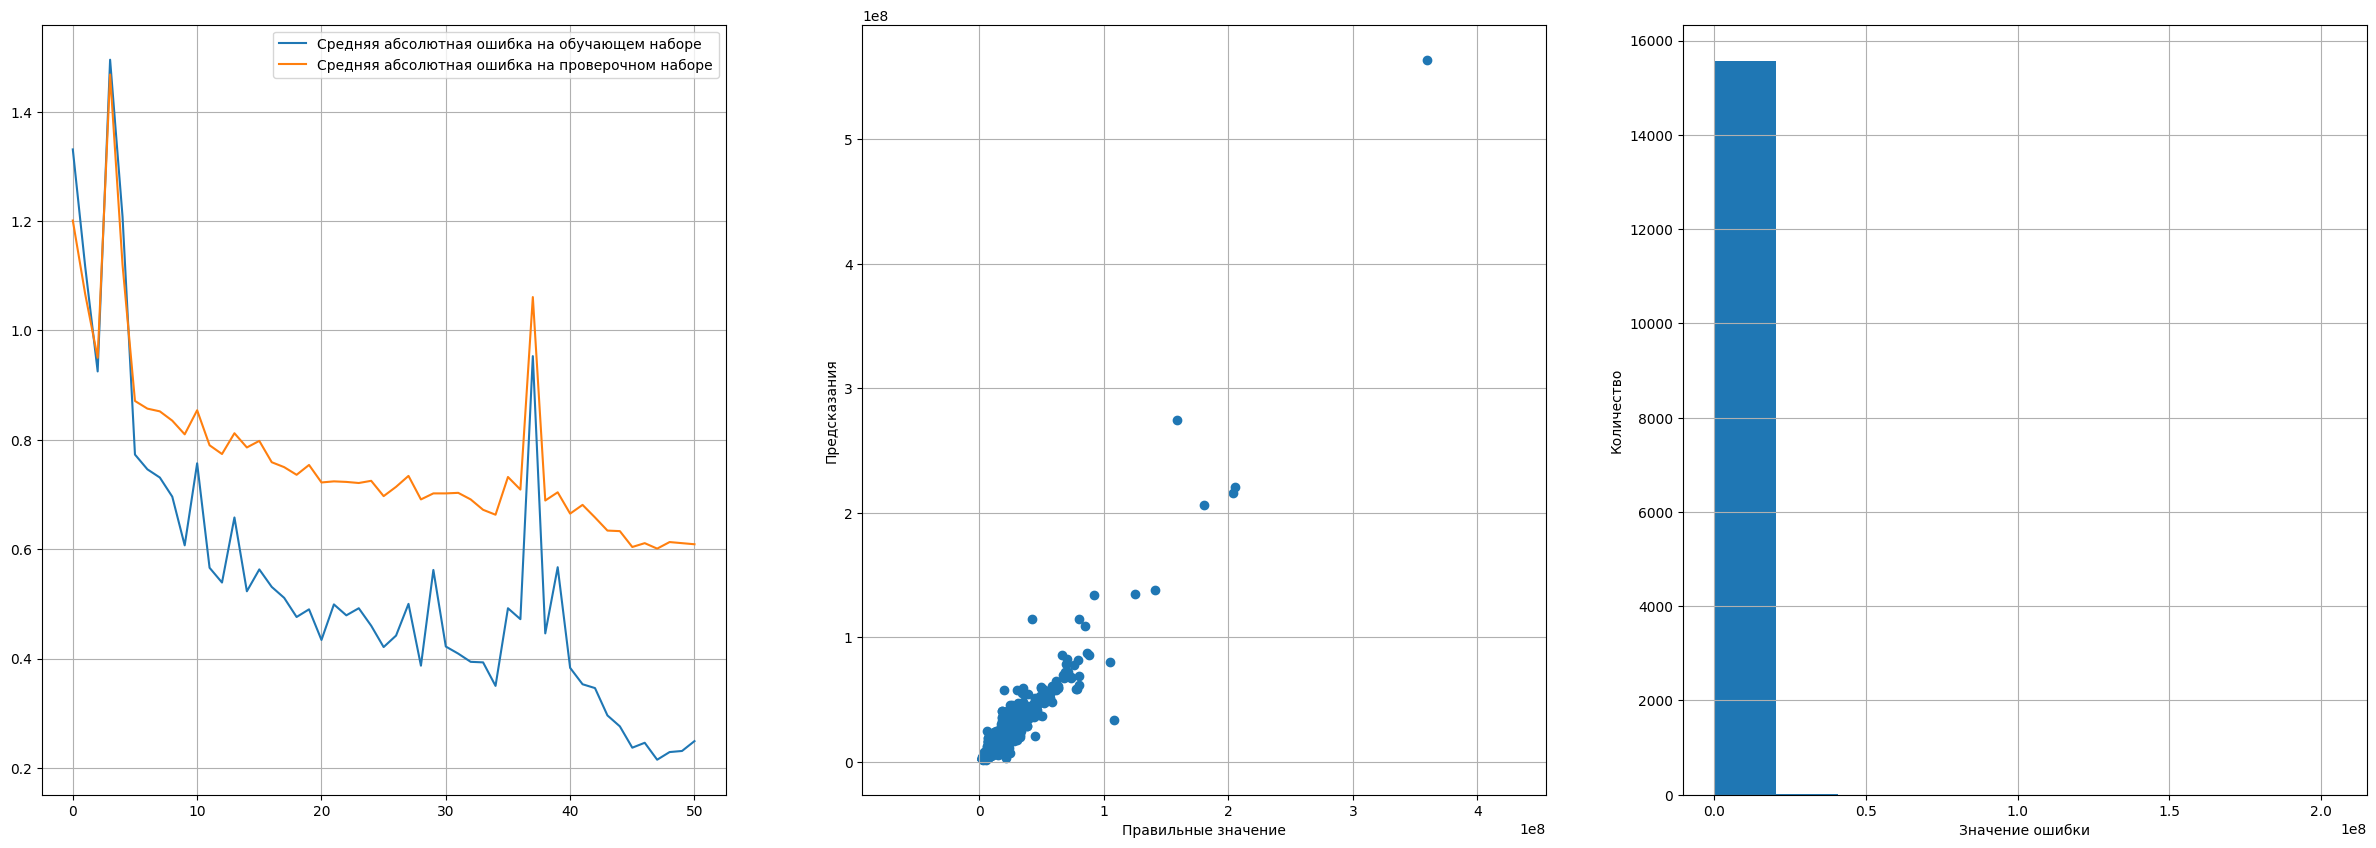

Время работы коллбэка:  35.053147077560425 секунд


In [16]:
#Dense сеть
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC.shape[1],))

x1 = Dense(10, activation="relu")(input1)
x2 = Dense(800, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(600, activation='relu')(x)
x = Dense(400, activation='relu')(x)
x = Dense(200, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)
time_start = [time.time()]

model.compile(optimizer=Adam(lr=lr), loss='mae')

history = model.fit([xTrainScaled[~valMask], xTrainC[~valMask]],
                    yTrainScaled[~valMask],
                    epochs=epochs,
                    validation_data=([xTrainScaled[valMask], xTrainC[valMask]],
                    yTrainScaled[valMask]),
                    verbose=0,
                    callbacks=[pltMae, reduce_lr])